In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.interpolate import CubicSpline

def compute_curvature(points):
    """计算曲线的曲率
    
    Args:
        points: shape (N, 2) 的点序列
    Returns:
        曲率序列
    """
    # 计算一阶导数
    dx = np.gradient(points[:, 0])
    dy = np.gradient(points[:, 1])
    
    # 计算二阶导数
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    # 计算曲率
    curvature = np.abs(dx * ddy - dy * ddx) / (dx * dx + dy * dy) ** 1.5
    return curvature

class DTWLoss(nn.Module):
    """Dynamic Time Warping损失函数"""
    def __init__(self):
        super(DTWLoss, self).__init__()
        
    def forward(self, pred_seq, true_seq):
        """
        Args:
            pred_seq: (batch_size, seq_len, 2)
            true_seq: (batch_size, seq_len, 2)
        """
        batch_size = pred_seq.shape[0]
        total_loss = 0
        
        for i in range(batch_size):
            # 计算距离矩阵
            D = torch.cdist(pred_seq[i], true_seq[i], p=2)
            
            # 动态规划计算DTW
            n, m = D.shape
            cost = torch.zeros_like(D)
            cost[0, 0] = D[0, 0]
            
            for j in range(1, n):
                cost[j, 0] = cost[j-1, 0] + D[j, 0]
            for j in range(1, m):
                cost[0, j] = cost[0, j-1] + D[0, j]
                
            for j in range(1, n):
                for k in range(1, m):
                    cost[j, k] = D[j, k] + torch.min(torch.stack([
                        cost[j-1, k],
                        cost[j, k-1],
                        cost[j-1, k-1]
                    ]))
            
            total_loss += cost[-1, -1]
        
        return total_loss / batch_size

class CurvatureLoss(nn.Module):
    """曲率相似度损失"""
    def __init__(self):
        super(CurvatureLoss, self).__init__()
    
    def forward(self, pred_seq, true_seq):
        """
        Args:
            pred_seq: (batch_size, seq_len, 2)
            true_seq: (batch_size, seq_len, 2)
        """
        batch_size = pred_seq.shape[0]
        total_loss = 0
        
        for i in range(batch_size):
            pred_curv = compute_curvature(pred_seq[i].detach().cpu().numpy())
            true_curv = compute_curvature(true_seq[i].detach().cpu().numpy())
            
            pred_curv = torch.tensor(pred_curv, device=pred_seq.device)
            true_curv = torch.tensor(true_curv, device=true_seq.device)
            
            total_loss += torch.mean((pred_curv - true_curv) ** 2)
            
        return total_loss / batch_size

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=1):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, (hidden, cell)

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers=1):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(output_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden, cell):
        # x shape: (batch_size, 1, output_dim)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.fc(output)
        return prediction, (hidden, cell)

class Seq2SeqCurve(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, n_layers=2):
        super(Seq2SeqCurve, self).__init__()
        
        self.encoder = Encoder(input_dim, hidden_dim, n_layers)
        self.decoder = Decoder(output_dim, hidden_dim, n_layers)
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src shape: (batch_size, src_seq_len, input_dim)
        # trg shape: (batch_size, trg_seq_len, output_dim)
        
        batch_size = src.shape[0]
        trg_seq_len = trg.shape[1]
        output_dim = trg.shape[2]
        
        outputs = torch.zeros(batch_size, trg_seq_len, output_dim).to(src.device)
        
        # 编码器前向传播
        _, (hidden, cell) = self.encoder(src)
        
        # 第一个输入是起始点
        decoder_input = trg[:, 0:1, :]
        
        for t in range(1, trg_seq_len):
            output, (hidden, cell) = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = output
            
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            decoder_input = trg[:, t:t+1, :] if teacher_force else output
            
        return outputs

def train_model(model, train_loader, n_epochs, learning_rate=0.001, lambda_curvature=0.1):
    """训练模型
    
    Args:
        model: Seq2SeqCurve模型
        train_loader: 训练数据加载器
        n_epochs: 训练轮数
        learning_rate: 学习率
        lambda_curvature: 曲率损失权重
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dtw_criterion = DTWLoss()
    curvature_criterion = CurvatureLoss()
    
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        
        for batch_idx, (src, trg) in enumerate(train_loader):
            src, trg = src.to(device), trg.to(device)
            
            optimizer.zero_grad()
            output = model(src, trg)
            
            dtw_loss = dtw_criterion(output, trg)
            curvature_loss = curvature_criterion(output, trg)
            loss = dtw_loss + lambda_curvature * curvature_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}')

=== 显示原始SVG曲线 ===


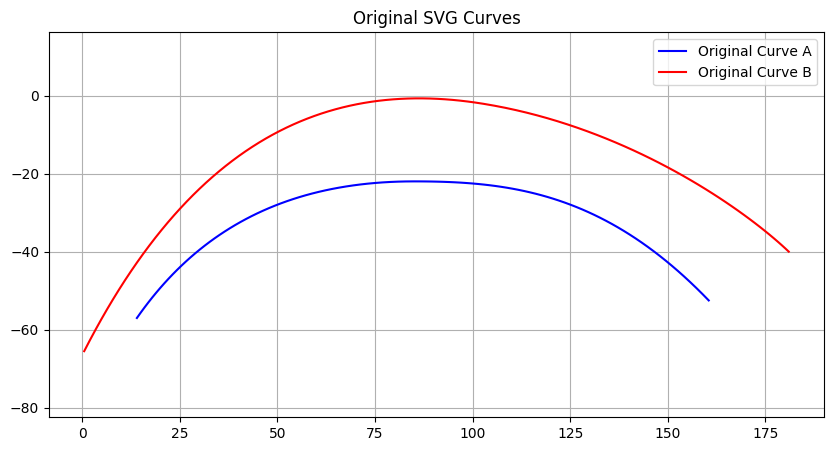


=== 训练模型 ===
Batch 0, Loss: 61.2546

=== 可视化结果 ===


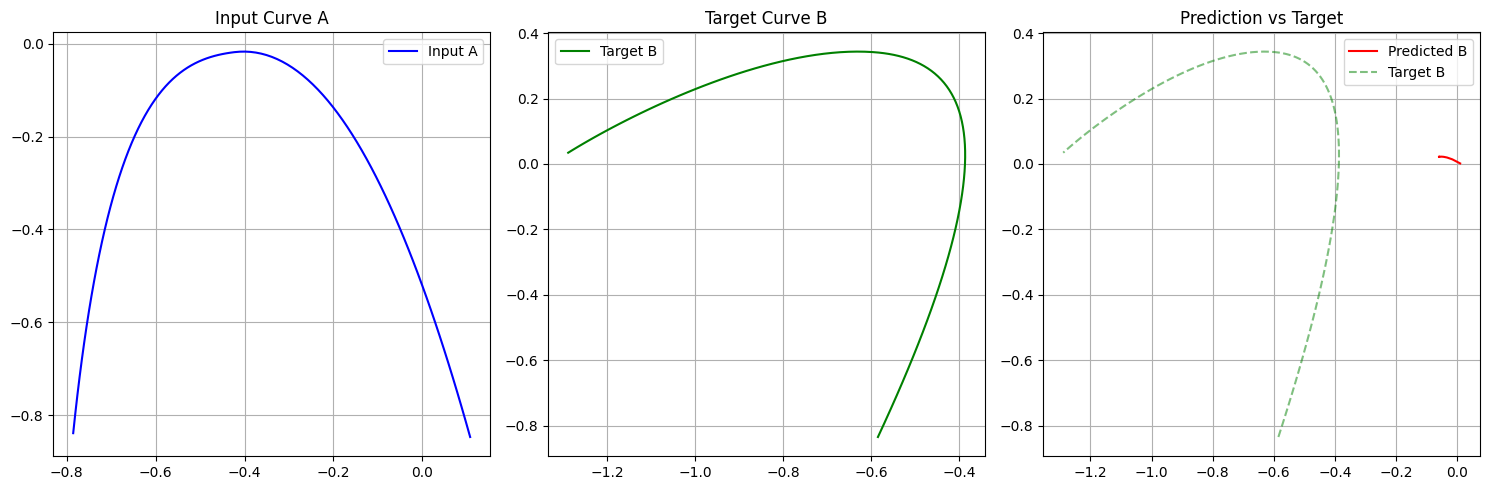

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from svg.path import parse_path
from svg.path import Line, CubicBezier, QuadraticBezier
import re
from typing import List, Tuple
import random
import matplotlib.pyplot as plt

# [前面的 SVGPathProcessor 和 CurvePairDataset 类保持不变...]

# 添加神经网络模型相关的类
class DTWLoss(nn.Module):
    """Dynamic Time Warping损失函数"""
    def __init__(self):
        super(DTWLoss, self).__init__()
        
    def forward(self, pred_seq, true_seq):
        batch_size = pred_seq.shape[0]
        total_loss = 0
        
        for i in range(batch_size):
            D = torch.cdist(pred_seq[i], true_seq[i], p=2)
            n, m = D.shape
            cost = torch.zeros_like(D)
            cost[0, 0] = D[0, 0]
            
            for j in range(1, n):
                cost[j, 0] = cost[j-1, 0] + D[j, 0]
            for j in range(1, m):
                cost[0, j] = cost[0, j-1] + D[0, j]
                
            for j in range(1, n):
                for k in range(1, m):
                    cost[j, k] = D[j, k] + torch.min(torch.stack([
                        cost[j-1, k],
                        cost[j, k-1],
                        cost[j-1, k-1]
                    ]))
            
            total_loss += cost[-1, -1]
        
        return total_loss / batch_size

class Seq2SeqCurve(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super(Seq2SeqCurve, self).__init__()
        self.hidden_dim = hidden_dim
        
        # 编码器
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # 解码器
        self.decoder = nn.LSTM(output_dim, hidden_dim, batch_first=True)
        # 输出层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = src.shape[1]  # 假设输出序列长度与输入相同
        
        outputs = torch.zeros(batch_size, trg_len, 2).to(src.device)
        
        # 编码器
        encoder_outputs, (hidden, cell) = self.encoder(src)
        
        # 解码器输入的第一个点
        decoder_input = src[:, 0:1, :]  # 使用源序列的第一个点
        
        for t in range(trg_len):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            output = self.fc(decoder_output)
            outputs[:, t:t+1, :] = output
            
            # 教师强制
            if trg is not None and random.random() < teacher_forcing_ratio:
                decoder_input = trg[:, t:t+1, :]
            else:
                decoder_input = output
        
        return outputs

def plot_original_svg_curves(curve_a_path, curve_b_path):
    """显示原始SVG曲线"""
    def get_raw_points(d):
        path = parse_path(d)
        points = []
        for i in range(100):
            distance = (i / 99) * path.length()
            point = path.point(distance / path.length())
            # SVG坐标系y轴向下，所以y坐标需要取负
            points.append((point.real, -point.imag))
        return np.array(points)
    
    points_a = get_raw_points(curve_a_path)
    points_b = get_raw_points(curve_b_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(points_a[:,0], points_a[:,1], 'b-', label='Original Curve A')
    plt.plot(points_b[:,0], points_b[:,1], 'r-', label='Original Curve B')
    plt.title('Original SVG Curves')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

def test_and_visualize():
    # 测试数据
    example_pairs = [
        (
            "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5",
            "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"
        ),
        (
            "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5",
            "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"
        )
    ]
    
    # 1. 显示原始SVG曲线
    print("=== 显示原始SVG曲线 ===")
    plot_original_svg_curves(example_pairs[0][0], example_pairs[0][1])
    
    # 2. 创建数据加载器
    train_loader = create_dataloader(
        curve_pairs=example_pairs,
        batch_size=2,
        num_points=100,
        augment=True,
        shuffle=True
    )
    
    # 3. 创建和训练模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Seq2SeqCurve().to(device)
    criterion = DTWLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 4. 训练一个epoch
    print("\n=== 训练模型 ===")
    model.train()
    for batch_idx, (src, trg) in enumerate(train_loader):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        
        loss.backward()
        optimizer.step()
        
        print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # 5. 可视化结果
        print("\n=== 可视化结果 ===")
        with torch.no_grad():
            model.eval()
            output = model(src, trg, teacher_forcing_ratio=0)
            
            plt.figure(figsize=(15, 5))
            
            # 原始数据
            plt.subplot(131)
            plt.plot(src[0,:,0].cpu(), src[0,:,1].cpu(), 'b-', label='Input A')
            plt.title('Input Curve A')
            plt.grid(True)
            plt.legend()
            
            # 目标数据
            plt.subplot(132)
            plt.plot(trg[0,:,0].cpu(), trg[0,:,1].cpu(), 'g-', label='Target B')
            plt.title('Target Curve B')
            plt.grid(True)
            plt.legend()
            
            # 预测结果
            plt.subplot(133)
            plt.plot(output[0,:,0].cpu(), output[0,:,1].cpu(), 'r-', label='Predicted B')
            plt.plot(trg[0,:,0].cpu(), trg[0,:,1].cpu(), 'g--', label='Target B', alpha=0.5)
            plt.title('Prediction vs Target')
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        break

if __name__ == "__main__":
    # test_and_visualize()

<svg width="182" height="66" viewBox="0 0 182 66" fill="none" xmlns="http://www.w3.org/2000/svg">
<path d="M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5" stroke="black"/>
<path d="M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40" stroke="black"/>
</svg>


Epoch [5/50], Loss: 70.6991


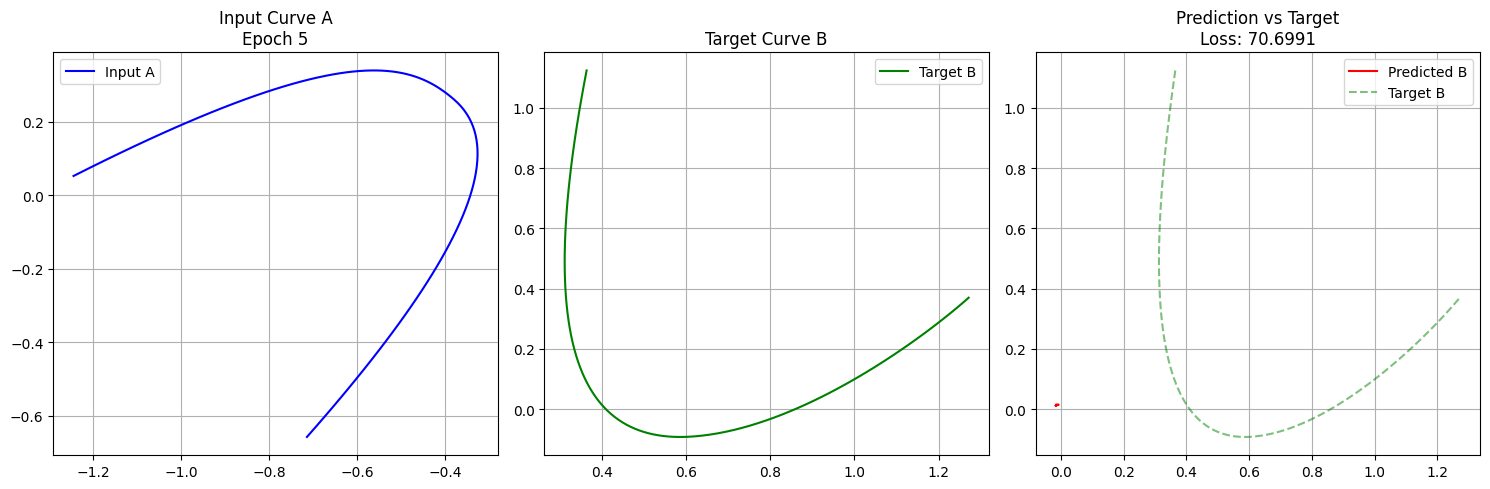

Epoch [10/50], Loss: 70.5986


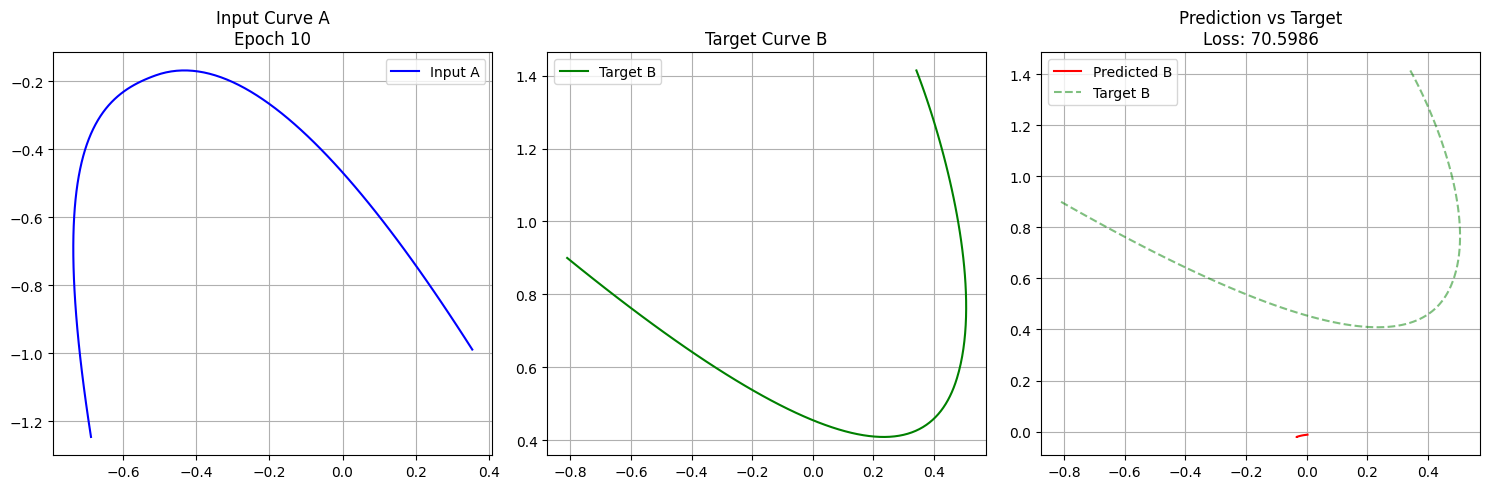

Epoch [15/50], Loss: 60.5663


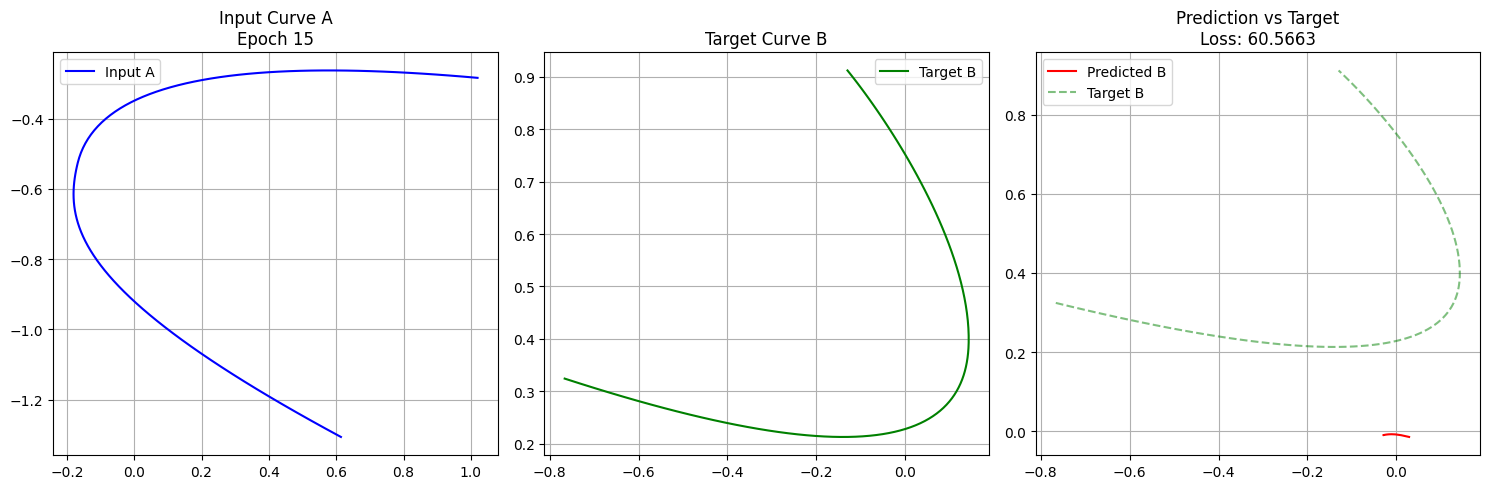

Epoch [20/50], Loss: 58.2730


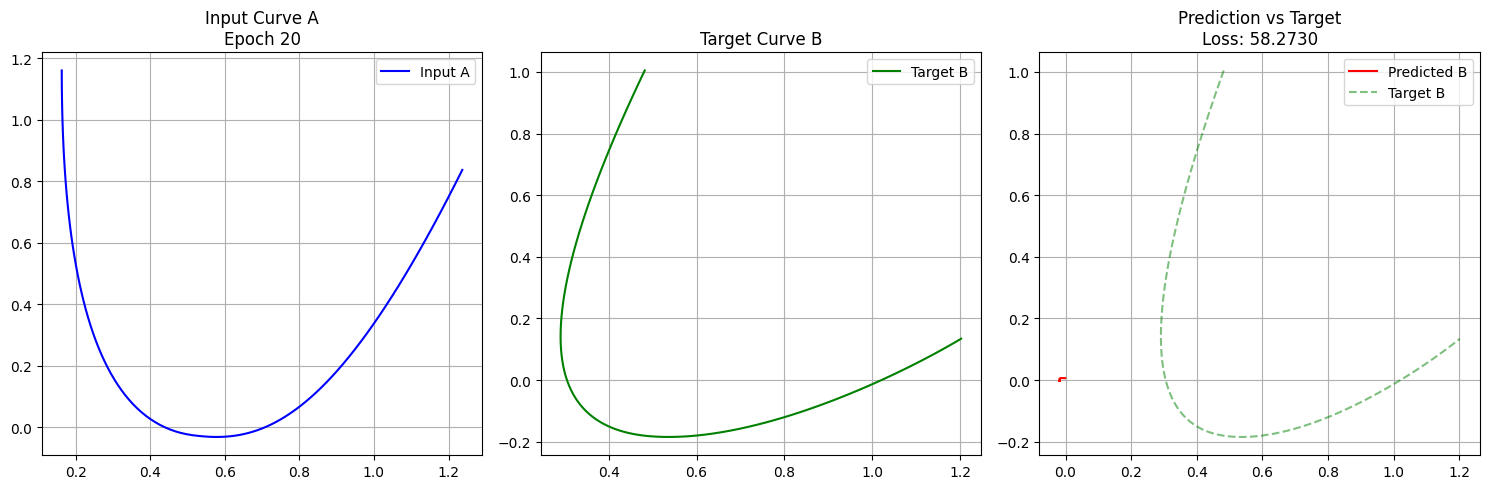

Epoch [25/50], Loss: 67.3716


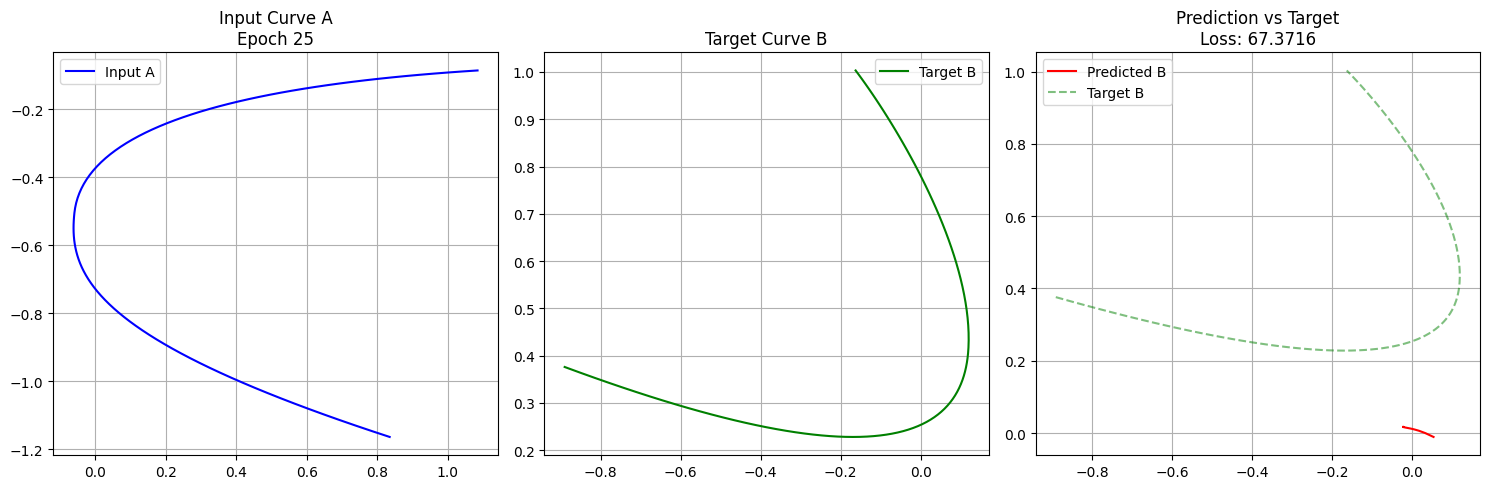

Epoch [30/50], Loss: 72.3401


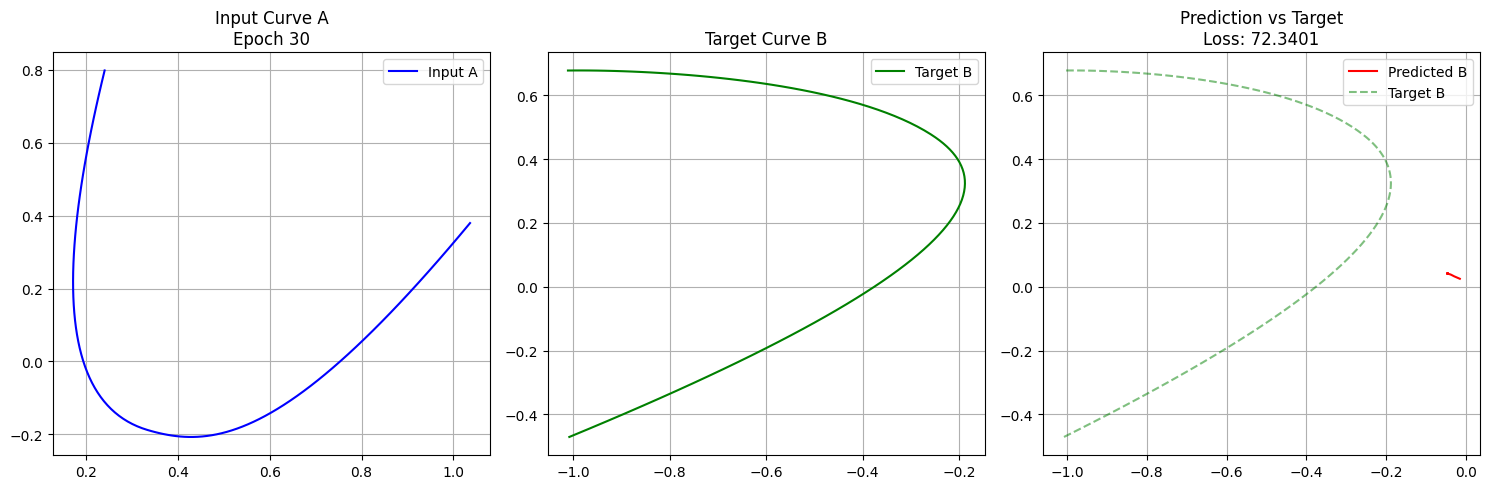

Epoch [35/50], Loss: 44.3514


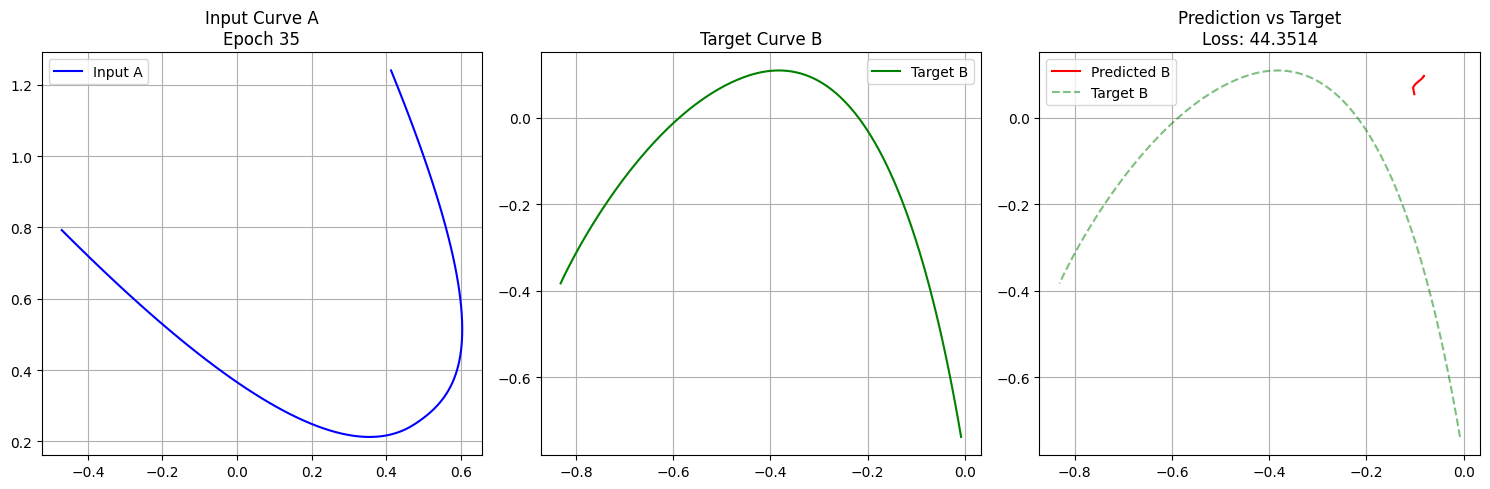

Epoch [40/50], Loss: 51.9654


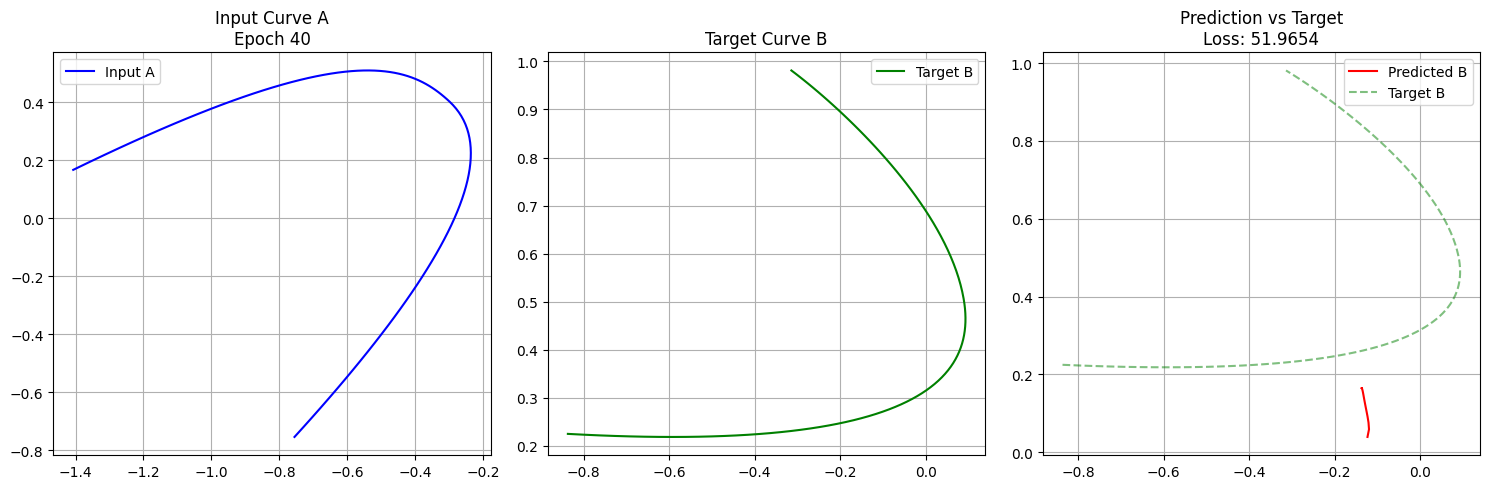

Epoch [45/50], Loss: 59.6822


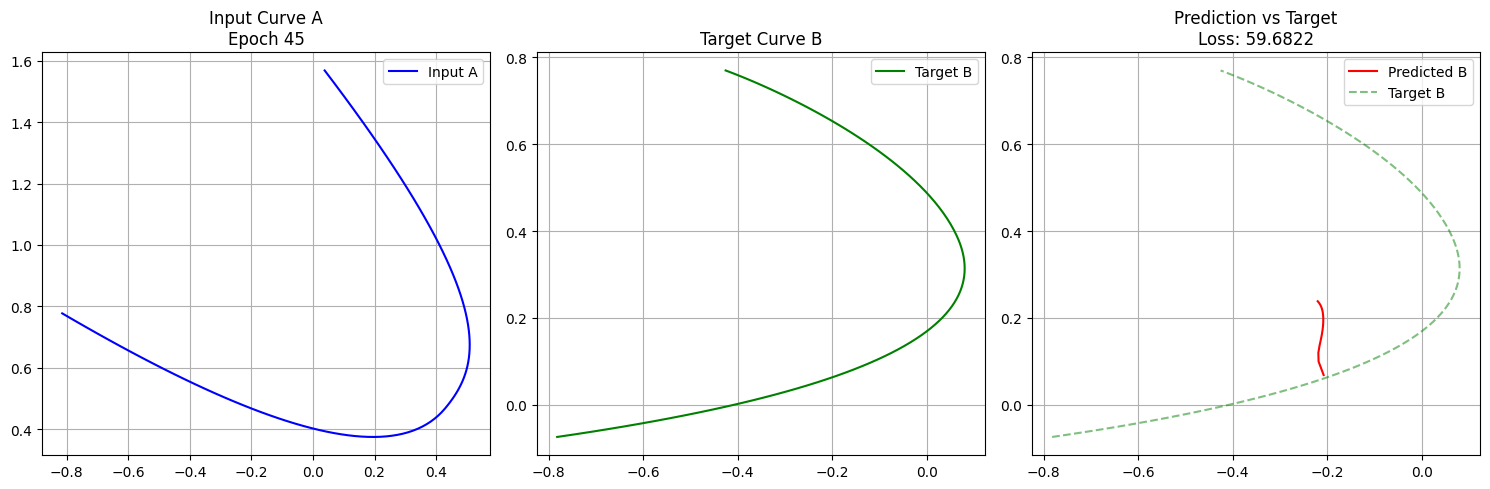

Epoch [50/50], Loss: 50.6964


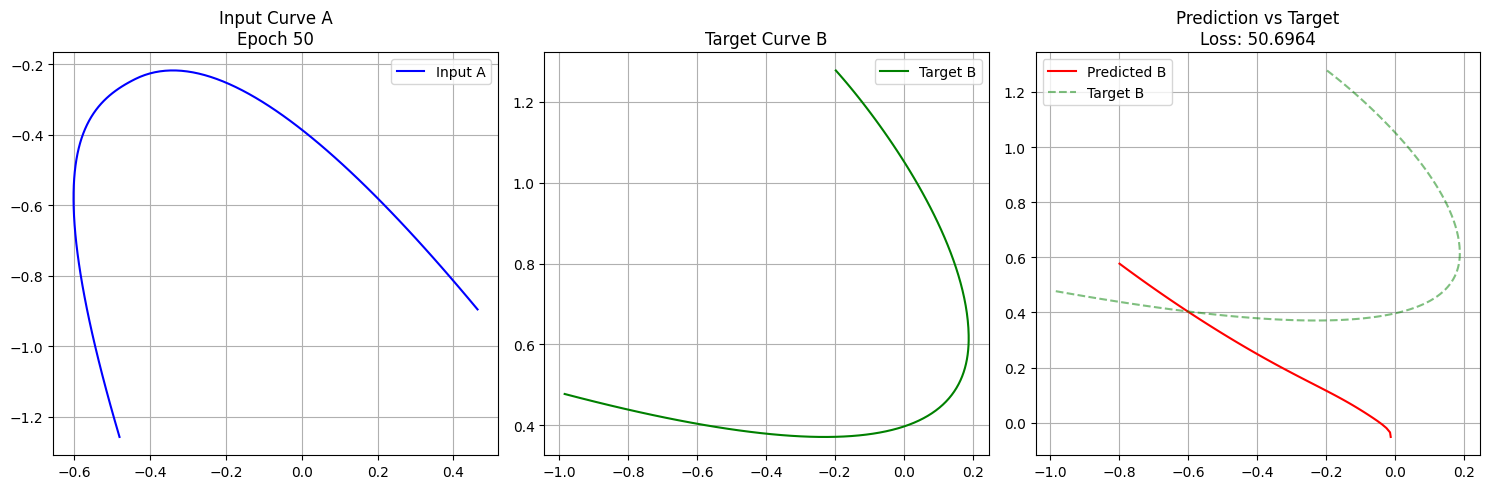

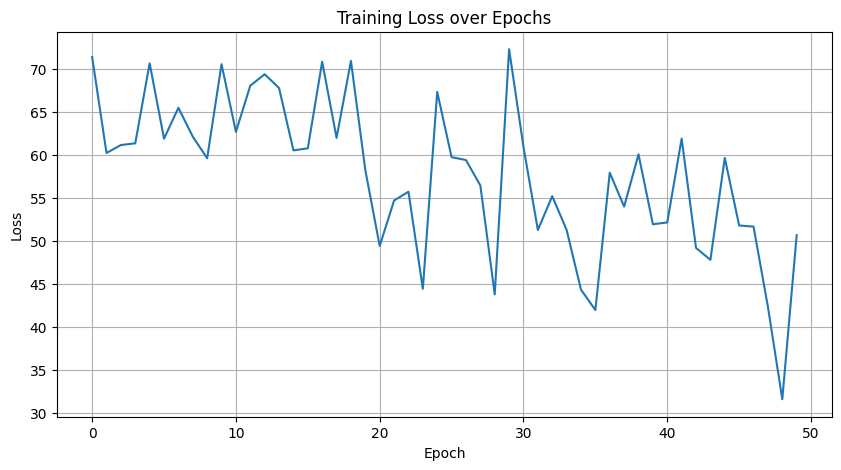

In [27]:
def train_and_visualize(num_epochs=50, print_every=5):
    """训练多个epoch并可视化训练过程"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Seq2SeqCurve().to(device)
    criterion = DTWLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 记录损失值
    losses = []
    
    # 训练多个epoch
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, (src, trg) in enumerate(train_loader):
            src, trg = src.to(device), trg.to(device)
            
            optimizer.zero_grad()
            output = model(src, trg)
            loss = criterion(output, trg)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)
        
        # 每隔一定epoch显示进度
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
            
            # 可视化当前预测结果
            with torch.no_grad():
                model.eval()
                src, trg = next(iter(train_loader))
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg, teacher_forcing_ratio=0)
                
                plt.figure(figsize=(15, 5))
                
                # 输入曲线A
                plt.subplot(131)
                plt.plot(src[0,:,0].cpu(), src[0,:,1].cpu(), 'b-', label='Input A')
                plt.title(f'Input Curve A\nEpoch {epoch+1}')
                plt.grid(True)
                plt.legend()
                
                # 目标曲线B
                plt.subplot(132)
                plt.plot(trg[0,:,0].cpu(), trg[0,:,1].cpu(), 'g-', label='Target B')
                plt.title('Target Curve B')
                plt.grid(True)
                plt.legend()
                
                # 预测结果
                plt.subplot(133)
                plt.plot(output[0,:,0].cpu(), output[0,:,1].cpu(), 'r-', label='Predicted B')
                plt.plot(trg[0,:,0].cpu(), trg[0,:,1].cpu(), 'g--', label='Target B', alpha=0.5)
                plt.title(f'Prediction vs Target\nLoss: {avg_epoch_loss:.4f}')
                plt.grid(True)
                plt.legend()
                
                plt.tight_layout()
                plt.show()
    
    # 显示损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# 运行训练
train_and_visualize(num_epochs=50, print_every=5)